In [1]:
!pip install -U -q statsmodels pmdarima

### Get data

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



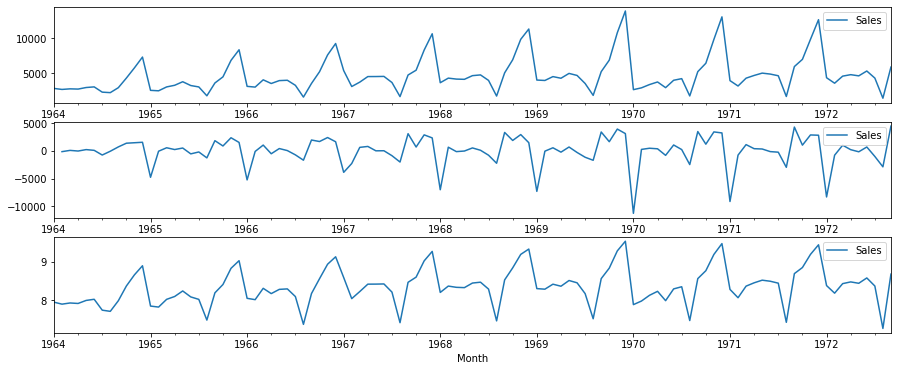

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('perrin-freres-monthly-champagne.csv', index_col='Month', parse_dates=True,
                 engine='python', skipfooter=2)  # ignores the last two junk lines at the end of the file
df.columns = ['Sales']
df.index.freq = df.index.inferred_freq
fig, ax = plt.subplots(nrows=3, figsize=(15,6))
df.plot(ax=ax[0]);
df.diff().plot(ax=ax[1]);
np.log(df).plot(ax=ax[2]);

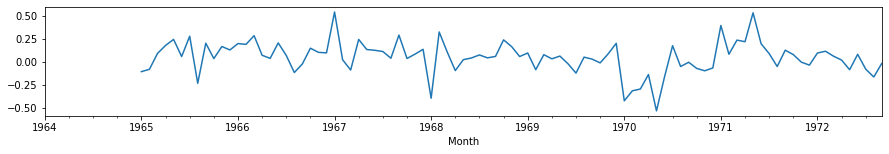

In [4]:
# Looking at the scales, we want to take log to reduce volatility.
# There is also a clear seasonal component with period=12
period = 12
df['LogSales'] = np.log(df['Sales'])
df['LogSales'].diff(period).plot(figsize=(15,2));

### Parameter selection with ADF, PACF, ACF

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ADF(df): 0.1868517311168746
ADF(df.diff()): 0.00023121404649533762



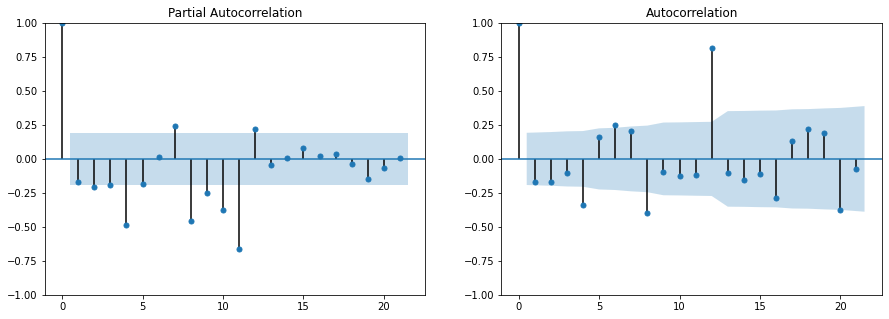

In [6]:
# If we don't consider seasonality, than p and q needs to be large: p=q=12
print(f"ADF(df): {adfuller(df['LogSales'])[1]}")
print(f"ADF(df.diff()): {adfuller(df['LogSales'].diff().dropna())[1]}")
print()
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
plot_pacf(df['LogSales'].diff().dropna(), ax[0], method='ywm');
plot_acf(df['LogSales'].diff().dropna(), ax[1]);

ADF(df.diff(12)): 0.005438393674347413



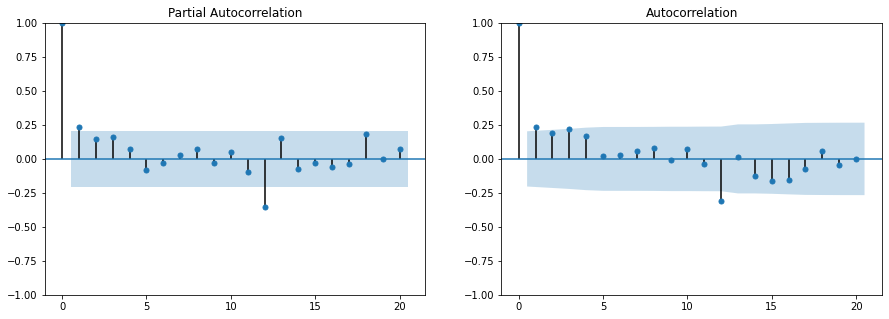

In [7]:
# With seasonality, p=q=1 are enough
print(f"ADF(df.diff({period})): {adfuller(df['LogSales'].diff(period).dropna())[1]}")
print()
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
plot_pacf(df['LogSales'].diff(period).dropna(), ax[0], method='ywm');
plot_acf(df['LogSales'].diff(period).dropna(), ax[1]);

### ARIMA(12,1,12)

In [8]:
from statsmodels.tsa.arima.model import ARIMA

Ntest = period
train = df.iloc[:-Ntest]['LogSales']
test = df.iloc[-Ntest:]['LogSales']
order = (12,1,12)

model = ARIMA(train, order=order)
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               LogSales   No. Observations:                   93
Model:               ARIMA(12, 1, 12)   Log Likelihood                  27.651
Date:                Sun, 09 Oct 2022   AIC                             -5.301
Time:                        16:00:24   BIC                             57.744
Sample:                    01-01-1964   HQIC                            20.144
                         - 09-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0133      0.418     -0.032      0.975      -0.833       0.806
ar.L2         -0.0970      0.348     -0.279      0.780      -0.778       0.584
ar.L3         -0.1616      0.376     -0.430      0.667      -0.898       0.575
ar.L4         -0.1531      0.364     -0.420      0.674      -0.867       0.561
ar.L5         -0.0295      0.407     -0.073      0.942      -0.827       0.768
ar.L6         -0.0803      0.355     -0.226      0.821      -0.776       0.615
ar.L7         -0.1290      0.376     -0.343      0.731      -0.866       0.608
ar.L8         -0.1814      0.336     -0.540      0.589      -0.839       0.477
ar.L9         -0.0044      0.400     -0.011      0.991      -0.789       0.780
ar.L10        -0.0914      0.347     -0.263      0.792      -0.772       0.590
ar.L11        -0.1515      0.355     -0.426      0.670      -0.848       0.545
ar.L12         0.8055      0.340      2.370      0.018       0.139       1.472
ma.L1         -0.6659      0.434     -1.533      0.125      -1.517       0.185
ma.L2          0.0668      0.247      0.270      0.787      -0.418       0.552
ma.L3          0.0924      0.259      0.356      0.722      -0.416       0.601
ma.L4          0.0916      0.223      0.410      0.681      -0.346       0.529
ma.L5         -0.3633      0.247     -1.471      0.141      -0.848       0.121
ma.L6          0.1555      0.234      0.666      0.505      -0.302       0.613
ma.L7          0.0075      0.278      0.027      0.979      -0.537       0.552
ma.L8          0.2439      0.230      1.060      0.289      -0.207       0.695
ma.L9         -0.3866      0.250     -1.546      0.122      -0.877       0.103
ma.L10         0.3187      0.250      1.276      0.202      -0.171       0.808
ma.L11        -0.0269      0.292     -0.092      0.927      -0.599       0.545
ma.L12        -0.2674      0.185     -1.442      0.149      -0.631       0.096
sigma2         0.0246      0.005      4.796      0.000       0.015       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                12.70
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.64
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE = 0.1221
R2 = 0.9389



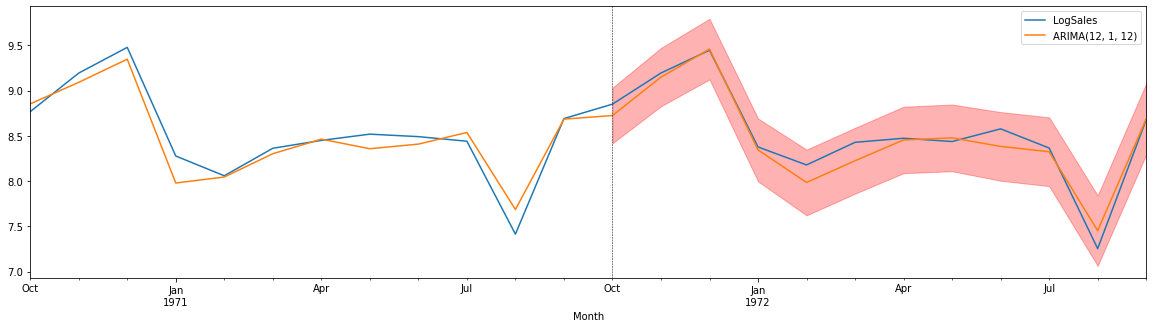

In [9]:
from sklearn.metrics import r2_score

# Add fitted values for train & test
forecast_ = res.get_forecast(Ntest)
forecast, confint = forecast_.predicted_mean, forecast_.conf_int().to_numpy()
df[f'ARIMA{order}'] = res.fittedvalues[period:]
df.loc[df.index[-Ntest]:,f'ARIMA{order}'] = forecast
# Score
print(f'RMSE = {np.sqrt(np.mean((forecast.to_numpy() - test.to_numpy())**2)):.4f}')
print(f'R2 = {r2_score(forecast.to_numpy(), test.to_numpy()):.4f}', end='\n\n')
# Plot
fig, ax = plt.subplots(figsize=(20,5))
df.iloc[-2*period:, df.columns!='Sales'].plot(ax=ax);
ax.legend();
ax.axvline(x=df.index[-Ntest], color='black', ls='--', lw=.5);
ax.fill_between(df.index[-Ntest:], *confint.transpose(), color='red', alpha=0.3);

### SARIMA(0,0,0)(1,1,1,s=12)



In [10]:
from statsmodels.tsa.arima.model import ARIMA

Ntest = period
train = df.iloc[:-Ntest]['LogSales']
test = df.iloc[-Ntest:]['LogSales']
order = (0,0,0)
seasonal_order = (1,1,1,12)

model = ARIMA(train, order=order, seasonal_order=seasonal_order)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                 LogSales   No. Observations:                   93
Model:             ARIMA(1, 1, [1], 12)   Log Likelihood                  21.553
Date:                  Sun, 09 Oct 2022   AIC                            -37.106
Time:                          16:00:27   BIC                            -29.923
Sample:                      01-01-1964   HQIC                           -34.224
                           - 09-01-1971                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7487      0.329     -2.278      0.023      -1.393      -0.104
ma.S.L12       0.5217      0.395      1.321      0.186      -0.252       1.296
sigma2         0.0336      0.005      7.400      0.000       0.025       0.043
===================================================================================
Ljung-Box (L1) (Q):                   6.32   Jarque-Bera (JB):                17.52
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.59
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE = 0.1323
R2 = 0.9361



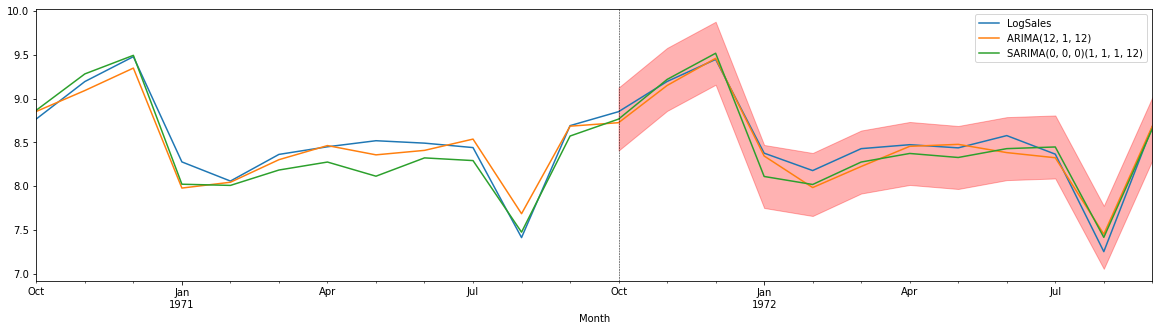

In [11]:
# Add fitted values for train & test
forecast_ = res.get_forecast(Ntest)
forecast, confint = forecast_.predicted_mean, forecast_.conf_int().to_numpy()
df[f'SARIMA{order}{seasonal_order}'] = res.fittedvalues[period:]
df.loc[df.index[-Ntest]:,f'SARIMA{order}{seasonal_order}'] = forecast
# Score
print(f'RMSE = {np.sqrt(np.mean((forecast.to_numpy() - test.to_numpy())**2)):.4f}')
print(f'R2 = {r2_score(forecast.to_numpy(), test.to_numpy()):.4f}', end='\n\n')
# Plot
fig, ax = plt.subplots(figsize=(20,5))
df.iloc[-2*period:, df.columns!='Sales'].plot(ax=ax);
ax.legend();
ax.axvline(x=df.index[-Ntest], color='black', ls='--', lw=.5);
ax.fill_between(df.index[-Ntest:], *confint.transpose(), color='red', alpha=0.3);

### Auto-ARIMA

In [12]:
import pmdarima as pm

Ntest = period
train = df.iloc[:-Ntest]['LogSales']
test = df.iloc[-Ntest:]['LogSales']

auto = pm.auto_arima(train, seasonal=True, m=period, trace=True, suppress_warnings=True)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-50.502, Time=5.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-41.975, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-54.968, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-53.384, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-34.700, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-44.102, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-52.971, Time=2.88 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-52.991, Time=1.61 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-55.117, Time=1.14 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-53.123, Time=2.53 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-50.817, Time=1.53 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-56.122, Time=0.71 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-44.178, Time=0.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   93
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  33.917
Date:                            Sun, 09 Oct 2022   AIC                            -57.834
Time:                                    16:01:15   BIC                            -45.862
Sample:                                01-01-1964   HQIC                           -53.031
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0083      0.011      0.773      0.440      -0.013       0.029
ar.L1          0.8620      0.160      5.381      0.000       0.548       1.176
ma.L1         -0.6698      0.220     -3.045      0.002      -1.101      -0.239
ma.S.L12      -0.4796      0.116     -4.118      0.000      -0.708      -0.251
sigma2         0.0244      0.003      8.573      0.000       0.019       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.77
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.68
Prob(H) (two-sided):                  0.51   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE = 0.1089
R2 = 0.9516



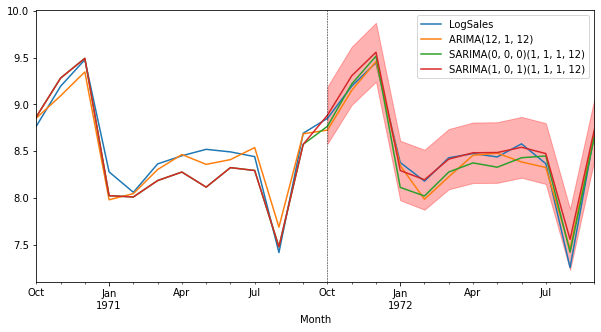

In [13]:
auto_order = auto.get_params()['order']
auto_seasonal_order = auto.get_params()['seasonal_order']
# Add fitted values for train & test
forecast, conf_int = auto.predict(Ntest, return_conf_int=True)
df[f'SARIMA{auto_order}{seasonal_order}'] = res.fittedvalues[period:]
df.loc[df.index[-Ntest]:,f'SARIMA{auto_order}{seasonal_order}'] = forecast
# Score
print(f'RMSE = {np.sqrt(np.mean((forecast.to_numpy() - test.to_numpy())**2)):.4f}')
print(f'R2 = {r2_score(forecast.to_numpy(), test.to_numpy()):.4f}', end='\n\n')
# Plot
fig, ax = plt.subplots(figsize=(10,5))
df.iloc[-2*period:, df.columns!='Sales'].plot(ax=ax);
ax.legend();
ax.axvline(x=df.index[-Ntest], color='black', ls='--', lw=.5);
ax.fill_between(df.index[-Ntest:], *conf_int.transpose(), color='red', alpha=0.3);
plt.show()